In [1]:
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import gym
import numpy as np
import sys
sys.path.append("../../")
from Hack import load, rl
%matplotlib qt5

In [2]:
epex = load.epex().load()
price_array = epex['apx_da_hourly'].values

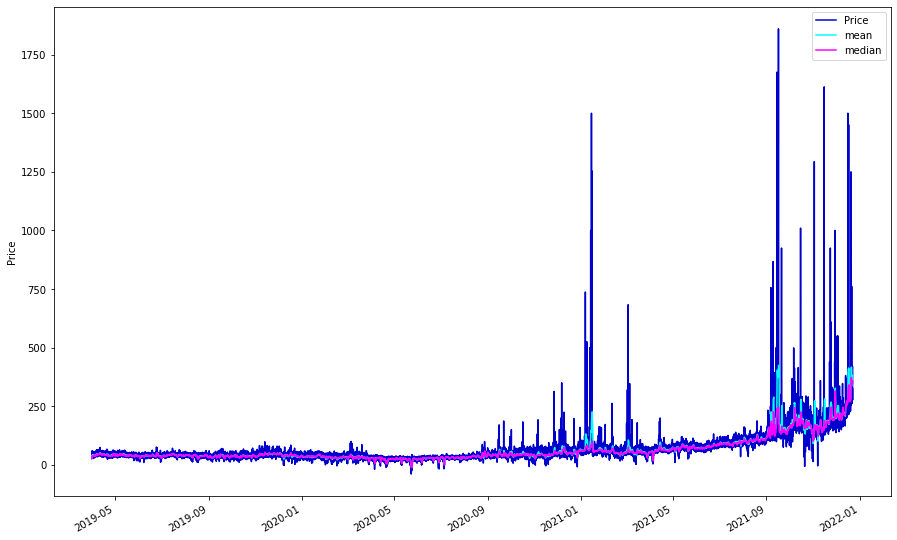

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, axs = plt.subplots(1,1, figsize = (15,10))
axs.plot(epex.index, price_array, color = 'mediumblue', label='Price')
mean_prices = []
median_prices = []
for i in np.arange(price_array.shape[0]):
    mean_prices.append(rl.get_expected_price(price_array, i, mode = 'mean'))
    median_prices.append(rl.get_expected_price(price_array, i, mode = 'median', window_size=2*24))
    
axs.plot(epex.index, mean_prices, color = 'cyan', label='mean')
axs.plot(epex.index, median_prices, color = 'magenta', label='median')

axs.set_ylabel("Price")
axs.legend()
fig.autofmt_xdate()

In [4]:
start_of_2020 = None
start_of_2021 = None

for idx, (i, row) in enumerate(epex.iterrows()):
    if i.year > 2019 and start_of_2020 is None:
        start_of_2020 = idx
    if i.year > 2020 and start_of_2021 is None:
        start_of_2021 = idx
        break
print(start_of_2020, start_of_2021)

13202 30770


In [5]:
start_idx = 0
end_idx = start_of_2020 #4 * 2*24*7 #start_of_2020 # 2019->2020 # 2*24*7
obs_price_array = price_array[start_idx:end_idx]

power = 0.5
env = rl.energy_price_env(obs_price_array, window_size=24*2, power=power)
model = PPO(MlpPolicy, env, verbose=0)
check_env(env, warn=True)

C:\Users\Ronan\Anaconda3\envs\ml\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Mean reward: 103.08613 +/- 0.0 	 Num episodes: 1


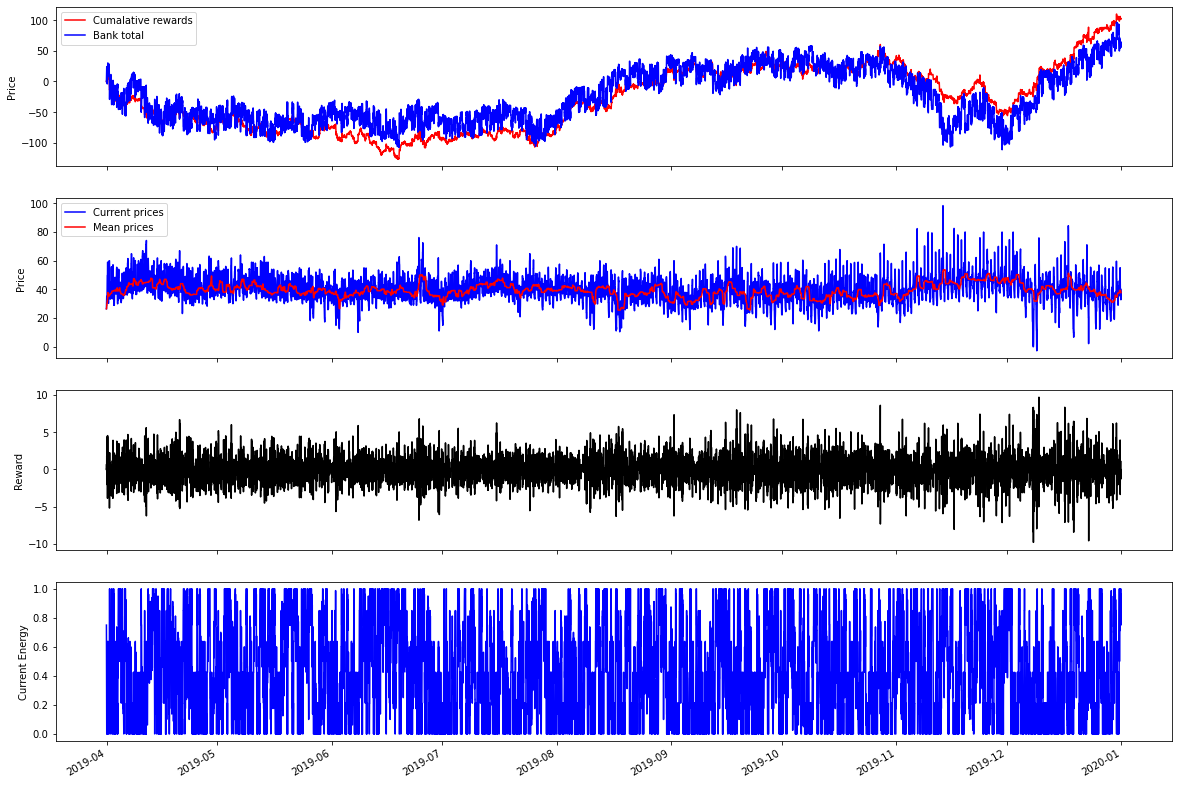

In [6]:
mean_reward_before_train = rl.evaluate(model, num_episodes=1, index = epex.index[start_idx:end_idx])

In [ ]:
# Train the agent for 10000 steps
model.learn(total_timesteps=50000)
#model.save("../model_dir/trained_model")

# load model using loaded_model = PPO.load("path_to_model")

In [ ]:
# model.save("Models/train_first_month")

In [ ]:
# Trained Agent, after training
period = 'all'
# period = 'sept'

if period == 'sept':
    # test on september
    test_start_idx = 42434 # end_idx # start_of_2020 # end_idx # start_of_2020 # 2*24*7
    test_end_idx =  test_start_idx + 4*7*24*2 # -1 # start_of_2021 # 2*end_idx # start_of_2021 # 30770 + 2*24*7
elif period == 'all':
    test_start_idx = 4*7*24*2
    test_end_idx =  -1
elif period == '2020':
    test_start_idx = start_of_2020
    test_end_idx =  start_of_2021
elif period == '2021':
    test_start_idx = start_of_2021
    test_end_idx =  -1

test_price_array = price_array[test_start_idx:test_end_idx]

new_env =  DummyVecEnv([lambda: rl.energy_price_env(test_price_array, power=power)])
mean_reward_after_train = rl.evaluate(model, new_env=new_env, num_episodes=2, index=epex.index[test_start_idx:test_end_idx])